In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/stock-prediction-dataset-adp/ADP-Data.csv


# load the dataset

In [2]:
data_dir = '/kaggle/input/stock-prediction-dataset-adp/ADP-Data.csv'
# to ingnore the first col use [index_col=0]
data = pd.read_csv(data_dir,index_col=0)
data[:10]

,Date,High,Low,Open,Close,Volume,Adj Close
0,1980-03-17,0.927141,0.908554,0.0,0.917847,1158040.1,0.520855
1,1980-03-18,0.930239,0.914749,0.0,0.927141,1622063.1,0.525637
2,1980-03-19,0.942631,0.927141,0.0,0.942631,1367859.1,0.533608
3,1980-03-20,0.961218,0.939533,0.0,0.939533,3046412.1,0.532014
4,1980-03-21,0.948826,0.936435,0.0,0.936435,1020851.1,0.530420
5,1980-03-24,0.942631,0.930239,0.0,0.930239,778752.1,0.527231
6,1980-03-25,0.942631,0.927141,0.0,0.930239,944186.1,0.527231
7,1980-03-26,0.942631,0.927141,0.0,0.942631,2332220.1,0.533608
8,1980-03-27,0.930239,0.911652,0.0,0.911652,770682.1,0.517667
9,1980-03-28,0.942631,0.930239,0.0,0.936435,459988.1,0.530420


# a little data analysis 

In [3]:
# check if it is null data 
data.isnull().sum()

Date         0
High         0
Low          0
Open         0
Close        0
Volume       0
Adj Close    0
dtype: int64

## plotting high and low 


In [4]:
import matplotlib.pyplot as plt 
high = data['High']
low = data['Low']

### convert 'Date' col from object to date

In [5]:
time = data['Date']
time.duplicated().sum()
# time[:5]


0

In [6]:
time[:5]

0    1980-03-17
1    1980-03-18
2    1980-03-19
3    1980-03-20
4    1980-03-21
Name: Date, dtype: object

In [7]:
time = pd.to_datetime(time)
time[:5]

0   1980-03-17
1   1980-03-18
2   1980-03-19
3   1980-03-20
4   1980-03-21
Name: Date, dtype: datetime64[ns]

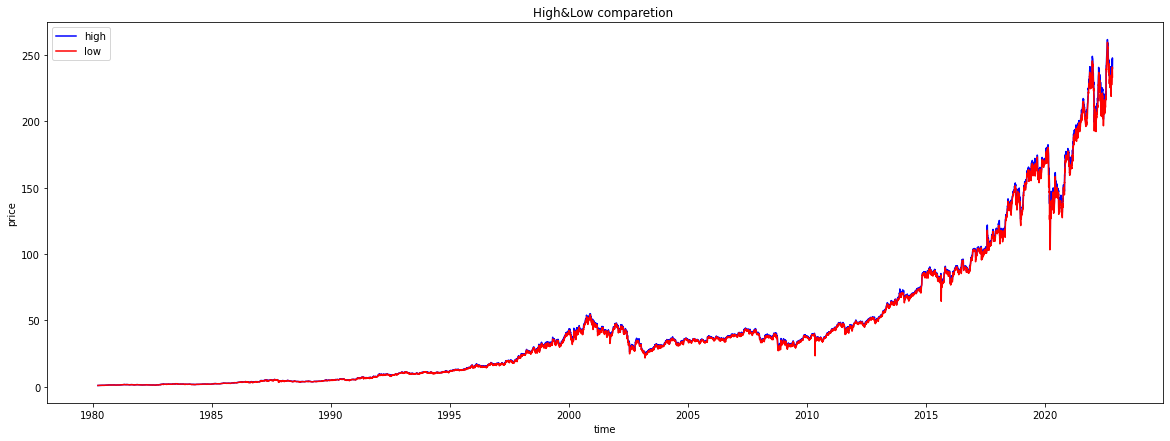

In [8]:
plt.figure(figsize = (20,7))
plt.plot(time,high,color='blue',label='high')
plt.plot(time,low,color='red',label='low')
plt.title('High&Low comparetion ')
plt.xlabel('time')
plt.ylabel('price')
plt.legend(title='')
plt.show()

###  same as open and close 

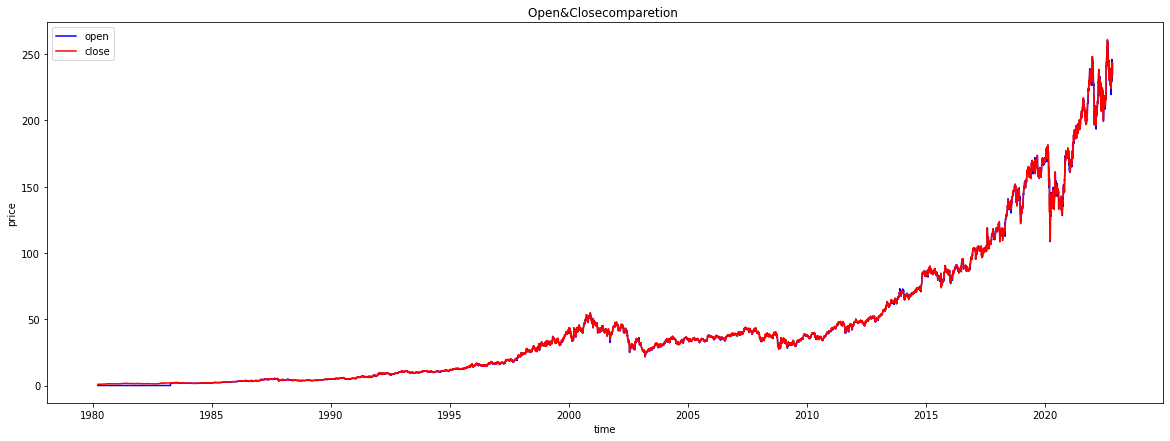

In [9]:
open_data = data['Open']
close_data = data['Close']
plt.figure(figsize = (20,7))
plt.plot(time,open_data,color='blue',label='open')
plt.plot(time,close_data,color='red',label='close')
plt.title('Open&Closecomparetion ')
plt.xlabel('time')
plt.ylabel('price')
plt.legend(title='')
plt.show()

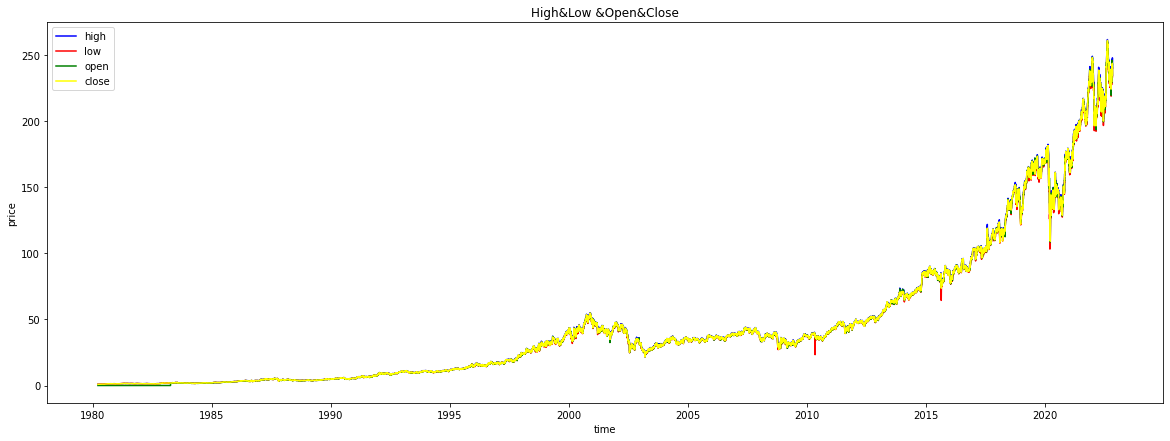

In [10]:
plt.figure(figsize = (20,7))
plt.plot(time,high,color='blue',label='high')
plt.plot(time,low,color='red',label='low')
plt.plot(time,open_data,color='green',label='open')
plt.plot(time,close_data,color='yellow',label='close')
plt.title('High&Low &Open&Close')
plt.xlabel('time')
plt.ylabel('price')
plt.legend(title='')
plt.show()

# predict close through lstm

## set up datasets


In [11]:
import math
from sklearn.preprocessing import MinMaxScaler
time = data['Date']
close = data['Close']
# Regularization close
scaler = MinMaxScaler(feature_range=(0,1))
scaler_data = scaler.fit_transform(close.values.reshape(-1,1))

In [12]:
scaler_data[:10]

array([[2.38152002e-05],
       [5.95436144e-05],
       [1.19091124e-04],
       [1.07181576e-04],
       [9.52722578e-05],
       [7.14531622e-05],
       [7.14531622e-05],
       [1.19091124e-04],
       [0.00000000e+00],
       [9.52722578e-05]])

In [13]:
from sklearn.model_selection import train_test_split
train_data,test_data = train_test_split(scaler_data,test_size=0.2)
print(len(scaler_data),len(train_data),len(test_data))

10752 8601 2151


 Create a 360-days window of historical prices (i-360) as our feature data (x_train) and the following 360-days window as label data (y_train).

In [14]:
x_train = []
y_train = []
for i in range(360,len(train_data)):
    x_train.append(train_data[i-360:i,0])
    y_train.append(train_data[i,0])

convert the feattures data and label data into np.array

In [15]:
x_train,y_train = np.array(x_train),np.array(y_train)
x_train = np.reshape(x_train,(x_train.shape[0],x_train.shape[1],1))


## prepare the test set

## set up the model

In [16]:
import tensorflow as tf 
from tensorflow.keras.layers import Dense,LSTM,Dropout
import tensorflow.keras.layers as layers
model = tf.keras.Sequential()
model.add(layers.LSTM(8,return_sequences=True,input_shape=(x_train.shape[1],1)))
model.add(layers.LSTM(16,return_sequences=True))
model.add(Dropout(0.2))
model.add(Dense(10))
model.add(Dense(1))
model.summary()

2022-12-09 03:34:42.618765: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 360, 8)            320       
_________________________________________________________________
lstm_1 (LSTM)                (None, 360, 16)           1600      
_________________________________________________________________
dropout (Dropout)            (None, 360, 16)           0         
_________________________________________________________________
dense (Dense)                (None, 360, 10)           170       
_________________________________________________________________
dense_1 (Dense)              (None, 360, 1)            11        
Total params: 2,101
Trainable params: 2,101
Non-trainable params: 0
_________________________________________________________________


In [17]:
model.compile(optimizer='adam',loss='mse',metrics=['accuracy'])
history = model.fit(x_train,y_train,batch_size=8,epochs=5)

2022-12-09 03:34:43.412167: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/5
1031/1031 [==============================] - 208s 197ms/step - loss: 0.0439 - accuracy: 1.2134e-04
Epoch 2/5
1031/1031 [==============================] - 204s 198ms/step - loss: 0.0433 - accuracy: 1.2134e-04
Epoch 3/5
1031/1031 [==============================] - 203s 197ms/step - loss: 0.0434 - accuracy: 1.2134e-04
Epoch 4/5
1031/1031 [==============================] - 203s 197ms/step - loss: 0.0434 - accuracy: 1.2134e-04
Epoch 5/5
1031/1031 [==============================] - 204s 198ms/step - loss: 0.0434 - accuracy: 1.2134e-04


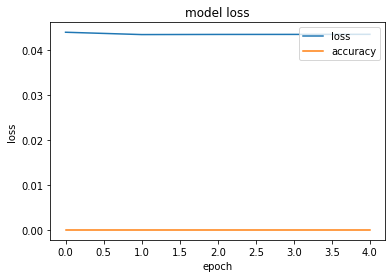

In [18]:
import matplotlib.pyplot as plt 

plt.plot(history.history['loss'])
plt.plot(history.history['accuracy'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss','accuracy'], loc='upper right')
plt.show()